In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

from sklearn.preprocessing import StandardScaler
import GPy

In [2]:
os.chdir('/home/saumya/Documents/FINAL_DATA_300/Spec')

In [3]:
x_dat = np.load('abs_SNR_clean_new.npy')
# x_dat = np.reshape(x_dat, -1)[:, None]

In [4]:
x_dat.shape

(12500, 3000)

In [5]:
x_dat

array([[0.000106  , 0.00010616, 0.0001063 , ..., 0.0003343 , 0.0003338 ,
        0.0003335 ],
       [0.000106  , 0.00010616, 0.0001063 , ..., 0.0003343 , 0.0003338 ,
        0.0003335 ],
       [0.000106  , 0.00010616, 0.0001063 , ..., 0.0003343 , 0.0003338 ,
        0.0003335 ],
       ...,
       [0.001553  , 0.001555  , 0.001558  , ..., 0.002968  , 0.002964  ,
        0.00296   ],
       [0.00155   , 0.001553  , 0.001555  , ..., 0.002964  , 0.00296   ,
        0.002958  ],
       [0.001547  , 0.00155   , 0.001553  , ..., 0.00296   , 0.002956  ,
        0.002954  ]], dtype=float16)

In [6]:
os.chdir('/home/saumya/Documents/FINAL_DATA_300/Param_profile')

In [7]:
y_dat_std = np.load('final_param_300.npy')

# y_dat = np.reshape(y_dat, -1)[:, None]

# y_dat = y_dat[:10000]

In [8]:
os.chdir('/home/saumya/Documents/FINAL_DATA_300/Model_data/LMC')

In [9]:
y_A1_T = StandardScaler().fit(np.reshape(y_dat_std[:,0],-1)[:,None])
y_A2_T = StandardScaler().fit(np.reshape(y_dat_std[:,1],-1)[:,None])
y_A3_T = StandardScaler().fit(np.reshape(y_dat_std[:,2],-1)[:,None])

In [10]:
y_A1_d = y_A1_T.transform(np.reshape(y_dat_std[:,0],-1)[:,None])
y_A2_d = y_A2_T.transform(np.reshape(y_dat_std[:,1],-1)[:,None])
y_A3_d = y_A3_T.transform(np.reshape(y_dat_std[:,2],-1)[:,None])

In [11]:
import pickle


with open('LMC_A1.pkl', 'wb') as file:
    pickle.dump(y_A1_T, file)

with open('LMC_A2.pkl', 'wb') as file:
    pickle.dump(y_A2_T, file)

with open('LMC_A3.pkl', 'wb') as file:
    pickle.dump(y_A3_T, file)

In [12]:
y_dat = np.column_stack((y_A1_d, y_A2_d, y_A3_d))

In [13]:
# import pickle

# import pickle
# with open('y_d_T_ICM.pkl', 'wb') as file:
#     pickle.dump(y_dat_transform, file)

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
def train_val_test_split(X, y, val_size):
    # test_size = 1 - train_size - val_size
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size = val_size)
    # relative_train_size = train_size / (val_size + train_size)
    # X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val,
                                                    #   train_size = relative_train_size, test_size = 1-relative_train_size)
    return X_train_val, X_test, y_train_val, y_test

In [16]:
X_train, X_test, Y_train, Y_test = train_val_test_split(x_dat, y_dat, .2)

In [17]:
(y_dat[2][0])

-1.697749375254331

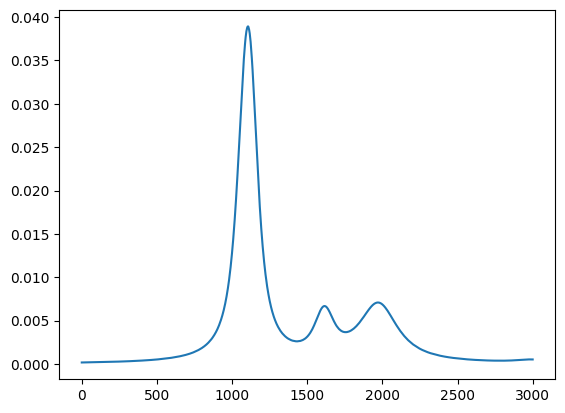

In [18]:
plt.plot(x_dat[1200])

In [19]:
max(x_dat[1200])

0.0389

In [20]:
# LMC set up
ks = [GPy.kern.RBF(np.shape(X_train)[1]) for i in range(1)]
icm = GPy.util.multioutput.LCM(input_dim=np.shape(X_train)[1],num_outputs=1,kernels_list=ks)

In [21]:
print(icm)
# print('W matrix\n',icm.B.W)
# print('\nkappa vector\n',icm.B.kappa)
# print('\nB matrix\n',icm.B.B)

  ICM0.            |         value  |  constraints  |  priors
  rbf.variance     |           1.0  |      +ve      |        
  rbf.lengthscale  |           1.0  |      +ve      |        
  B.W              |  [-1.0764046]  |               |        
  B.kappa          |           0.5  |      +ve      |        


In [22]:
Y_train.shape

(10000, 3)

In [23]:
m = GPy.models.GPCoregionalizedRegression([X_train],[Y_train],kernel=icm)
m['.*rbf.var'].constrain_fixed(1.)
# constrain if converge to reasonless extrema
# m['mixed_noise.Gaussian_noise_0.variance'].constrain_bounded(0,1e-5)
# m['mixed_noise.Gaussian_noise_1.variance'].constrain_bounded(0,1e-5)
# m['mixed_noise.Gaussian_noise_2.variance'].constrain_bounded(0,1e-5)
print(m)


Name : gp
Objective : 34869.378918835864
Number of Parameters : 5
Number of Optimization Parameters : 4
Updates : True
Parameters:
  gp.                                    |         value  |  constraints  |  priors
  ICM0.rbf.variance                      |           1.0  |   +ve fixed   |        
  ICM0.rbf.lengthscale                   |           1.0  |      +ve      |        
  ICM0.B.W                               |  [-1.0764046]  |               |        
  ICM0.B.kappa                           |           0.5  |      +ve      |        
  mixed_noise.Gaussian_noise_0.variance  |           1.0  |      +ve      |        


In [24]:
# print('W matrix\n',icm.B.W)
# print('\nkappa vector\n',icm.B.kappa)

In [25]:
m.optimize(messages=True)

In [26]:
with open('gpr_LMC_Norm.pkl', 'wb') as file:
    pickle.dump(m, file)

In [27]:
print(m)
# print('W matrix\n',icm.B.W)
# print('\nkappa vector\n',icm.B.kappa)
# print('\nB matrix\n',icm.B.B)


Name : gp
Objective : 15972.425068068962
Number of Parameters : 5
Number of Optimization Parameters : 4
Updates : True
Parameters:
  gp.                                    |                value  |  constraints  |  priors
  ICM0.rbf.variance                      |                  1.0  |   +ve fixed   |        
  ICM0.rbf.lengthscale                   |  0.20005777926041396  |      +ve      |        
  ICM0.B.W                               |      [-111.78755444]  |               |        
  ICM0.B.kappa                           |    9.613874551245926  |      +ve      |        
  mixed_noise.Gaussian_noise_0.variance  |   0.1315150579543501  |      +ve      |        


In [28]:
newX = X_test

In [29]:
newX = np.concatenate((newX,np.zeros((np.shape(X_test)[0],1))),1)
noise_dict = {'output_index':newX[:,-1].astype(int)}
ys_norm,var=m.predict(newX,Y_metadata=noise_dict)

# Temper_test_=scalerT.inverse_transform(ys)


In [30]:
ys_norm[:,0]

array([ 0.39425584, -0.11282599,  0.11445848, ..., -1.24094154,
       -0.30913597, -0.45279398])

In [31]:
Y_test[:,0]

array([ 0.38112741, -0.10394384,  0.10394384, ..., -1.21267813,
       -0.31183152, -0.4504233 ])

In [32]:
ys = np.zeros_like(ys_norm)
Y_test_real = np.zeros_like(Y_test)

In [33]:
ys[:, 0] = y_A1_T.inverse_transform(ys_norm[:,0].reshape(-1,1)).ravel()
ys[:, 1] = y_A2_T.inverse_transform(ys_norm[:,1].reshape(-1,1)).ravel()
ys[:, 2] = y_A3_T.inverse_transform(ys_norm[:,2].reshape(-1,1)).ravel()

In [34]:
Y_test_real[:, 0] = y_A1_T.inverse_transform(Y_test[:,0].reshape(-1,1)).ravel()
Y_test_real[:, 1] = y_A2_T.inverse_transform(Y_test[:,1].reshape(-1,1)).ravel()
Y_test_real[:, 2] = y_A3_T.inverse_transform(Y_test[:,2].reshape(-1,1)).ravel()

In [35]:
ys[:,0]-Y_test_real[:,0]

array([ 1.81721791, -1.22945429,  1.45542164, ..., -3.91218118,
        0.37311393, -0.32814601])

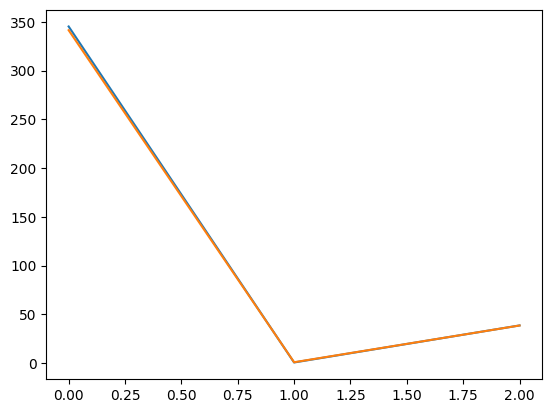

In [36]:
plt.plot(ys[1000])

plt.plot(Y_test_real[1000])

In [37]:
ys-Y_test_real

array([[ 1.81721791,  0.03186841,  0.35368989],
       [-1.22945429, -0.30407952,  1.56385696],
       [ 1.45542164, -0.00688619,  0.83384722],
       ...,
       [-3.91218118, -0.22611736,  2.45344091],
       [ 0.37311393,  0.03671002, -0.13014056],
       [-0.32814601, -0.13883392,  0.19035403]])

In [38]:
Y_test_real

array([[5.90755102e+02, 5.50000000e-01, 1.09183673e+01],
       [5.23612245e+02, 1.00000000e+00, 3.20408163e+00],
       [5.52387755e+02, 5.50000000e-01, 1.20204082e+01],
       ...,
       [3.70142857e+02, 7.75000000e-01, 3.73673469e+01],
       [4.94836735e+02, 5.50000000e-01, 3.29591837e+01],
       [4.75653061e+02, 7.75000000e-01, 4.17755102e+01]])

In [39]:
from sklearn import metrics

In [40]:
conc_1 = metrics.mean_squared_error(np.array(ys[:, 1]), np.array(Y_test_real[:, 1]))
print(f'The mean squared error between the real and predicted values are: {conc_1}')

The mean squared error between the real and predicted values are: 0.03421742490885235


In [41]:
conc_1 = metrics.mean_squared_error(np.array(ys[:, 2]), np.array(Y_test_real[:, 2]))
print(f'The mean squared error between the real and predicted values are: {conc_1}')

The mean squared error between the real and predicted values are: 9.979032504668764


In [42]:
conc_1 = metrics.mean_squared_error(np.array(ys[:, 0]), np.array(Y_test_real[:, 0]))
print(f'The mean squared error between the real and predicted values are: {conc_1}')

The mean squared error between the real and predicted values are: 104.33161259154761


In [43]:
metrics.mean_squared_error(ys, Y_test_real)

38.11495417370832

In [44]:
np.save("true_vals_lmc", Y_test_real)

In [45]:
np.save("pred_vals_lmc", ys)


In [46]:
pwd

'/home/saumya/Documents/FINAL_DATA_300/Model_data/LMC'